# Customer Churn Data Preparation & EDA
**Objective**: Prepare customer data for modeling using cleaning, feature engineering, and EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Understanding
Load dataset, print `.info()` and `.describe()`. Identify missing or strange values.

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print("--- Dataset Info ---")
df.info()

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

In [4]:
print("--- Numeric Summary ---")
display(df.describe())
print("--- Categorical Summary ---")
display(df.describe(include=['object']))

--- Numeric Summary ---


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


--- Categorical Summary ---


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [5]:
# Checking for strange values (like empty strings or spaces)
print("Count of spaces in object columns:")
for col in df.select_dtypes(include=['object']).columns:
    space_count = (df[col] == ' ').sum()
    if space_count > 0:
        print(f"{col}: {space_count}")

Count of spaces in object columns:
TotalCharges: 11


## 2. Data Cleaning
Fix data types, handle missing values, remove/flag invalid rows.

In [6]:
# Fix data types: TotalCharges is object -> float
# Replace spaces with NaN, then convert to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan))

# Handle missing values (impute or drop)
print(f"Missing values before dropping:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
# Since only 11 rows are missing TotalCharges, we can safely drop them
df = df.dropna(subset=['TotalCharges'])
print(f"\nShape after dropping invalid/missing rows: {df.shape}")

Missing values before dropping:
TotalCharges    11
dtype: int64

Shape after dropping invalid/missing rows: (7032, 21)


## 3. Feature Engineering
Create new columns: TenureGroup, AvgMonthlySpend. Convert binary to 1/0. One-hot encode categoricals.

In [7]:
# Create TenureGroup
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Create AvgMonthlySpend
# Use np.where to avoid division by zero if tenure is 0 (though cut handled inclusive lowest)
df['AvgMonthlySpend'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], df['MonthlyCharges'])

# Convert binary variables (yes/no) to 1/0
binary_cols = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Optional: Map gender
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encode categorical columns
# Selecting other categorical features to encode
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaymentMethod', 'TenureGroup']

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Shape after feature engineering: {df_encoded.shape}")
display(df_encoded.head())

# Save the cleaned and featured engineered dataframe to CSV
df_encoded.to_csv('CustomerChurn_Cleaned.csv', index=False)
print("Saved cleaned dataset to 'CustomerChurn_Cleaned.csv'")

Shape after feature engineering: (7032, 38)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_13-24,TenureGroup_25-36,TenureGroup_37-48,TenureGroup_49-60,TenureGroup_61-72
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,0,1,0,1,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,0,0,0,1,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,0,0,1,0,0,0,0,0,0


Saved cleaned dataset to 'CustomerChurn_Cleaned.csv'


## 4. EDA & Visualization
Countplot, Barplot, Heatmap, Boxplot using Seaborn.

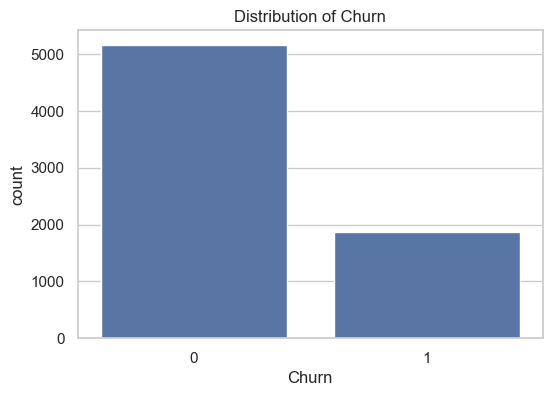

In [8]:
# Countplot for Churn
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Churn')
plt.show()

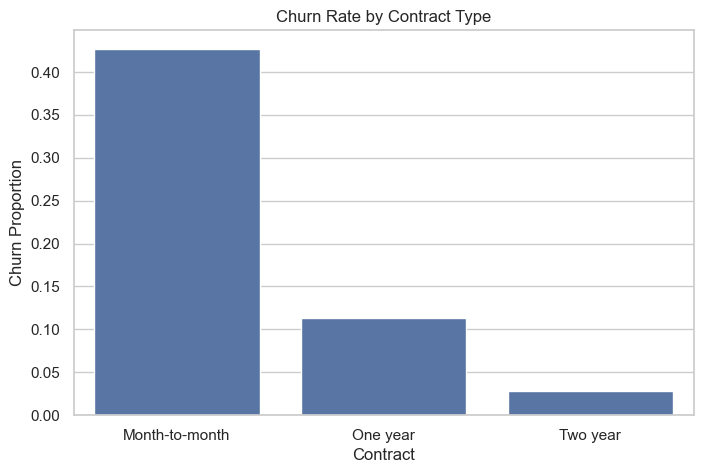

In [9]:
# Barplot: Contract vs Churn
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Contract', y='Churn', ci=None)
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Proportion')
plt.show()

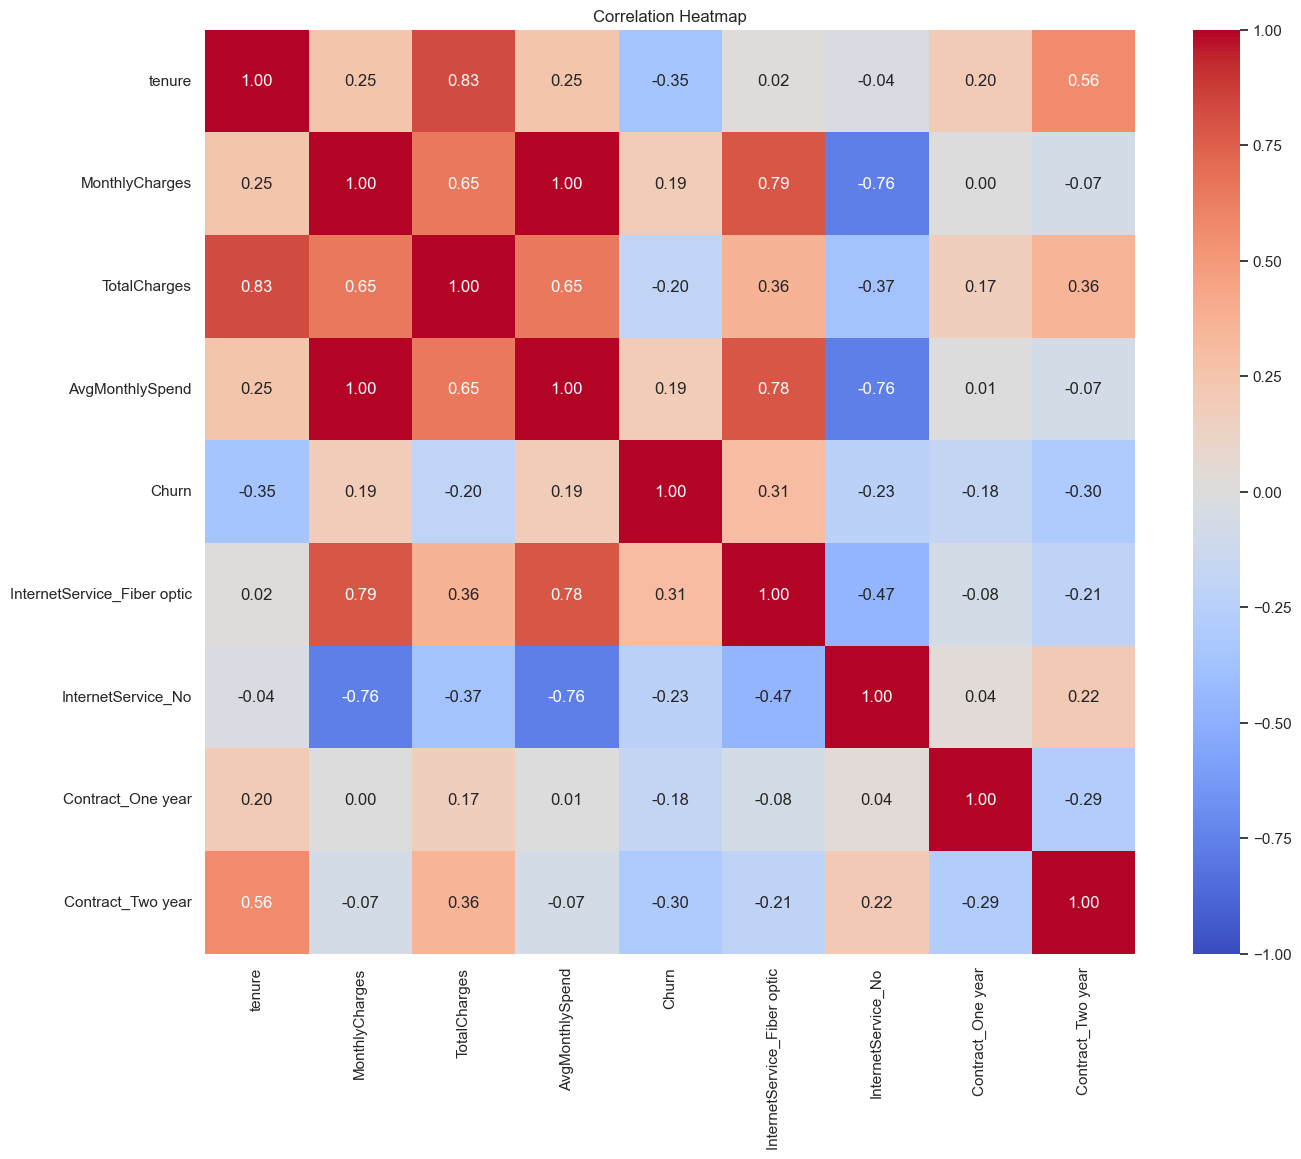

In [10]:
# Heatmap of correlations
# Compute the correlation matrix on numerical and encoded boolean variables
plt.figure(figsize=(15, 12))
corr_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'Churn']
# Plus a few encoded variables for visibility
corr_cols.extend([col for col in df_encoded.columns if 'Contract_' in col or 'InternetService_' in col])
corr = df_encoded[corr_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

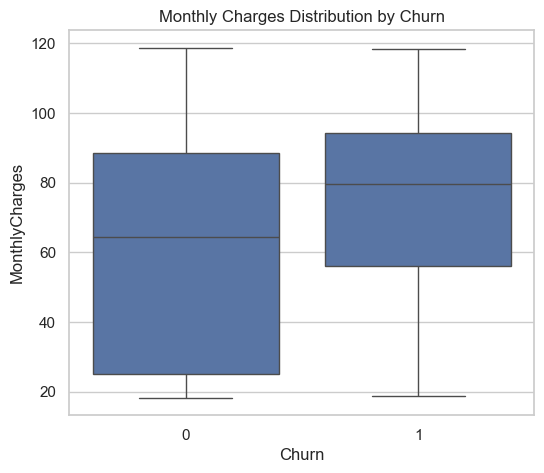

In [11]:
# Boxplot: MonthlyCharges by Churn
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges Distribution by Churn')
plt.show()

## 5. Insights & Conclusion

### Top 5 Insights
1. **Overall Churn Rate**: The overall churn rate in the dataset is **26.6%**.
2. **Contract Type Impact**: Month-to-month contracts have a significantly higher churn rate (**42.7%**) compared to Two-year contracts (**2.8%**).
3. **Monthly Charges**: Customers who churn tend to have higher average monthly charges (**$74.44**) compared to those who stay (**$61.31**).
4. **Internet Service Factor**: Customers with Fiber optic internet service have a notably high churn rate (**41.9%**).
5. **Billing Method**: Customers using Paperless Billing exhibit a higher churn rate (**33.6%**).

### Conclusion
The analysis clearly indicates that customer churn is strongly driven by contract length transparency, high service costs, and potentially the fiber optic service quality or pricing. Customers on month-to-month contracts and those with higher monthly charges are significantly more likely to leave the service.

**Recommendations:**
- Investigate the root cause behind the high churn rate of Fiber optic users.
- Incentivize customers to switch from month-to-month to one-year or two-year contracts through discounts or loyalty rewards.
- Offer targeted retention promotions when high monthly charge users show signs of disengagement.


In [13]:
# Save the final cleaned dataframe to a CSV file
df.to_csv("CustomerChurn_Cleaned_Task1_Final.csv", index=False)
print("Saved final dataset to 'CustomerChurn_Cleaned_Task1_Final.csv'")

Saved final dataset to 'CustomerChurn_Cleaned_Task1_Final.csv'
